In [55]:
# Import the necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import cv2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_class_weight

In [56]:
# Check the number of images in the dataset
train = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir('./train'):
  train_class = os.listdir(os.path.join('train', i))
  for j in train_class:
    img = os.path.join('train', i, j)
    train.append(img)
    label.append(i)

print('Number of train images : {} \n'.format(len(train)))

Number of train images : 3662 



In [57]:
No_images_per_class = []
Class_name = []
for i in os.listdir('./train'):
  train_class = os.listdir(os.path.join('train', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in Mild = 370 

Number of images in Moderate = 999 

Number of images in Proliferate_DR = 295 

Number of images in Severe = 193 

Number of images in No_DR = 1805 



In [58]:
retina_df = pd.DataFrame({'Image': train,'Labels': label})
retina_df

,Image,Labels
0,train/Mild/2d7666b8884f.png,Mild
1,train/Mild/50840c36f0b4.png,Mild
2,train/Mild/30cab14951ac.png,Mild
3,train/Mild/a8582e346df0.png,Mild
4,train/Mild/cab3dfa7962d.png,Mild
...,...,...
3657,train/No_DR/6b30767595d8.png,No_DR
3658,train/No_DR/2b4c7b5f1f1e.png,No_DR
3659,train/No_DR/ab78a66dee6a.png,No_DR
3660,train/No_DR/79ade634c633.png,No_DR


In [59]:
retina_df = shuffle(retina_df)
train, test = train_test_split(retina_df, test_size = 0.2)

In [60]:
# Update your ImageDataGenerator

import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class ImageProcessing:
    def __init__(self, img_height, img_width, no_channels, tol=7, sigmaX=8):
        self.img_height = img_height
        self.img_width = img_width
        self.no_channels = no_channels
        self.tol = tol
        self.sigmaX = sigmaX

    def cropping_2D(self, img, is_cropping=False):
        if not is_cropping:
            return img
        mask = img > self.tol
        return img[np.ix_(mask.any(1), mask.any(0))]

    def cropping_3D(self, img, is_cropping=False):
        if not is_cropping:
            return img
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > self.tol
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:
            return img
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

    def Gaussian_blur(self, img, is_gaussianblur=False):
        if not is_gaussianblur:
            return img
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), self.sigmaX), -4, 128)
        return img

    def draw_circle(self, img, is_drawcircle=True):
        if not is_drawcircle:
            return img
        x = int(self.img_width / 2)
        y = int(self.img_height / 2)
        r = np.amin((x, y))
        circle_img = np.zeros((self.img_height, self.img_width), np.uint8)
        cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
        img = cv2.bitwise_and(img, img, mask=circle_img)
        return img

    def image_preprocessing(self, img, is_cropping=True, is_gaussianblur=True, is_drawcircle=True):
        if img.ndim == 2:
            img = self.cropping_2D(img, is_cropping)
        else:
            img = self.cropping_3D(img, is_cropping)
        img = cv2.resize(img, (self.img_width, self.img_height), interpolation=cv2.INTER_AREA)
        if is_drawcircle:
            img = self.draw_circle(img)
        if is_gaussianblur:
            img = self.Gaussian_blur(img)
        return img

# Instantiate your preprocessing class
preprocessor = ImageProcessing(256, 256, 3)

# Update your ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range=0.2,
    vertical_flip=True,
    preprocessing_function=preprocessor.image_preprocessing,  # Add custom preprocessing function
    validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale = 1./255,preprocessing_function=preprocessor.image_preprocessing)

# Use this updated generator to load data
train_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

Found 2490 validated image filenames belonging to 5 classes.
Found 439 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


In [69]:
def res_block(X, filter, stage):
  
  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter
    
  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [70]:

input_shape = (256,256,3)

#Input tensor shape
X_input = Input(input_shape)

#Zero-padding

X = ZeroPadding2D((3,3))(X_input)

# 1 - stage

X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage

X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage

X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage

X = res_block(X, filter= [256,256,1024], stage= 4)

# # 5- stage

# X = res_block(X, filter= [512,512,2048], stage= 5)

#Average Pooling

X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

#Final layer

X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model.summary()

Model: "Resnet18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 262, 262,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 128, 128,  │      9,472 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 128, 128,  │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 128, 128,  │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 63, 63,    │          0 │ activation_28[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_a        │ (None, 63, 63,    │      4,160 │ max_pooling2d_19… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 31, 31,    │          0 │ res_2_conv_a[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_a         │ (None, 31, 31,    │        256 │ max_pooling2d_20… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 31, 31,    │          0 │ bn_2_conv_a[0][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_b        │ (None, 31, 31,    │     36,928 │ activation_29[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_b         │ (None, 31, 31,    │        256 │ res_2_conv_b[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 31, 31,    │          0 │ bn_2_conv_b[0][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_copy     │ (None, 63, 63,    │     16,640 │ max_pooling2d_19… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_c        │ (None, 31, 31,    │     16,640 │ activation_30[0]… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 31, 31,    │          0 │ res_2_conv_copy[… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_c         │ (None, 31, 31,    │      1,024 │ res_2_conv_c[0][

 Total params: 4,987,525 (19.03 MB)

 Trainable params: 4,967,685 (18.95 MB)

 Non-trainable params: 19,840 (77.50 KB)

In [37]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

checkpoint = ModelCheckpoint("model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

In [38]:
# Train the model using the generators
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20


/Users/avanaku/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.4737 - loss: 2.2289
Epoch 1: val_loss improved from inf to 1.20608, saving model to model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 64s 787ms/step - accuracy: 0.4747 - loss: 2.2217 - val_accuracy: 0.6036 - val_loss: 1.2061
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.6352 - loss: 1.1884
Epoch 2: val_loss improved from 1.20608 to 0.99992, saving model to model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 66s 829ms/step - accuracy: 0.6353 - loss: 1.1879 - val_accuracy: 0.7016 - val_loss: 0.9999
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.6736 - loss: 1.0510
Epoch 3: val_loss did not improve from 0.99992
78/78 ━━━━━━━━━━━━━━━━━━━━ 64s 794ms/step - accuracy: 0.6737 - loss: 1.0512 - val_accuracy: 0.7062 - val_loss: 1.0142
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6822 - loss: 1.0559  
Epoch 4: val_loss improved from 0.99992 to 0.94267, saving model to model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 86s 

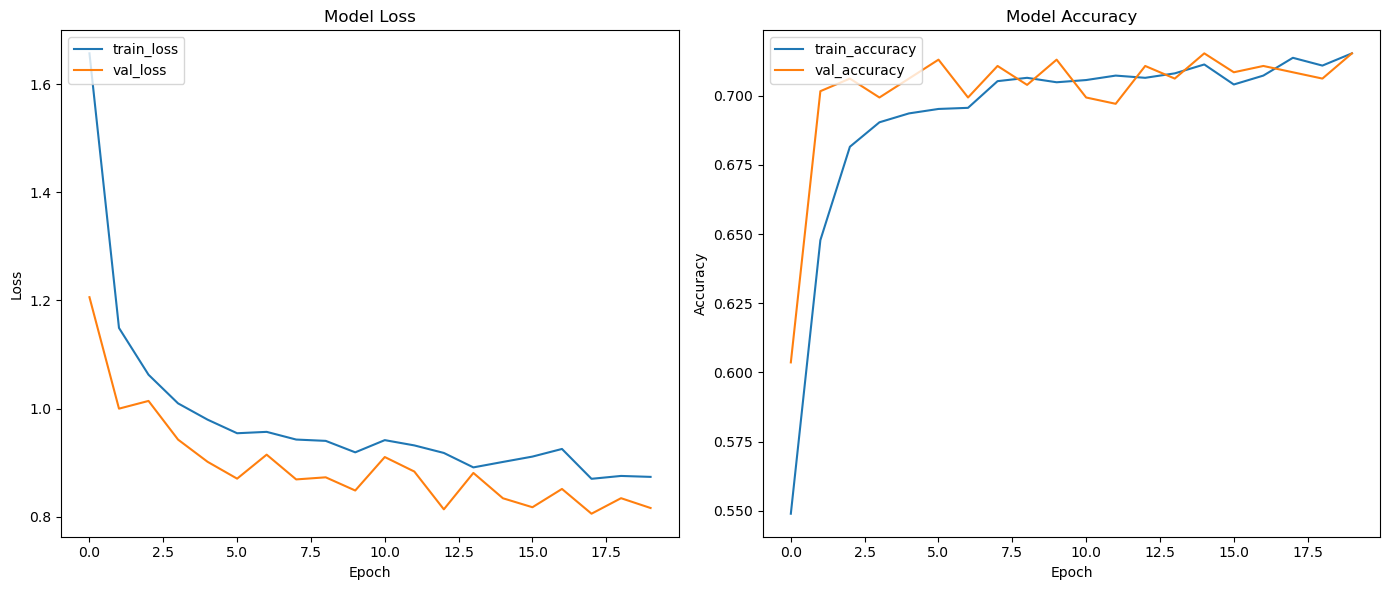

In [39]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plotting model loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['train_loss', 'val_loss'], loc='upper left')

# Plotting model accuracy
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('Model Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['train_accuracy', 'val_accuracy'], loc='upper left')

plt.tight_layout()
plt.show()


In [78]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])
model.load_weights("retina_weights.hdf5")

In [79]:
# Evaluate the performance of the model
evaluate = model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 0.8373 - loss: 0.4933
Accuracy Test : 0.8380681872367859


In [80]:
# Assigning label names to the corresponding indexes
labels = {0: 'Mild', 1: 'Moderate', 2: 'No_DR', 3:'Proliferate_DR', 4: 'Severe'}

In [81]:
# Loading images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2

prediction = []
original = []
image = []
count = 0

for item in range(len(test)):
  # code to open the image
  img= PIL.Image.open(test['Image'].tolist()[item])
  # resizing the image to (256,256)
  img = img.resize((256,256))
  # appending image to the image list
  image.append(img)
  # converting image to array
  img = np.asarray(img, dtype= np.float32)
  # normalizing the image
  img = img / 255
  # reshaping the image in to a 4D array
  img = img.reshape(-1,256,256,3)
  # making prediction of the model
  predict = model.predict(img)
  # getting the index corresponding to the highest value in the prediction
  predict = np.argmax(predict)
  # appending the predicted class to the list
  prediction.append(labels[predict])
  # appending original class to the list
  original.append(test['Labels'].tolist()[item])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

In [82]:
# Getting the test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.8308321964529332


In [83]:
# Print out the classification report
print(classification_report(np.asarray(original), np.asarray(prediction)))


                precision    recall  f1-score   support

          Mild       0.73      0.47      0.57        77
      Moderate       0.72      0.84      0.77       188
         No_DR       0.94      0.97      0.96       366
Proliferate_DR       0.63      0.67      0.65        61
        Severe       0.86      0.46      0.60        41

      accuracy                           0.83       733
     macro avg       0.78      0.68      0.71       733
  weighted avg       0.83      0.83      0.82       733

